In [253]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from unet import unet_model

from skimage.morphology import binary_erosion
from skimage.morphology import skeletonize

In [330]:
image_directory = 'dl_data/training/'
mask_directory = 'dl_data/ground_truth/'
SIZE = 1024
image_dataset = []
mask_dataset = []

images = os.listdir(image_directory)
images = sorted(images)
print(images)
for i, image_name in enumerate(images):
    if (image_name.split('.')[-1] == 'png'):
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
        image_dataset.append(np.array(image.rotate(90)))
        # image_dataset.append(np.array(image.rotate(120)))
        # image_dataset.append(np.array(image.rotate(150)))
        image_dataset.append(np.array(image.rotate(-90)))
        image_dataset.append(np.array(image.rotate(180)))

masks = os.listdir(mask_directory)
masks = sorted(masks)
print(masks)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        # image = Image.fromarray(image)
        # image = np.array(image).astype(bool)
        # image = skeletonize(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image).astype(bool))
        mask_dataset.append(np.array(image.rotate(90)).astype(bool))
        # mask_dataset.append(np.array(image.rotate(120)).astype(bool))
        # mask_dataset.append(np.array(image.rotate(150)).astype(bool))
        mask_dataset.append(np.array(image.rotate(-90)).astype(bool))
        mask_dataset.append(np.array(image.rotate(180)).astype(bool))

# for i, image_name in enumerate(masks):
#     if (image_name.split('.')[1] == 'png'):
#         image = cv2.imread(mask_directory+image_name, 0)
#         image = Image.fromarray(image)
#         image = image.resize((SIZE, SIZE))
#         mask_dataset.append(np.array(image))


['20230207_Me4_NPs_perov_1um.0_00009.png', '20230207_Me4_NPs_perov_5um.0_00006.png', '20230207_MeO_NPs_perov_1um.0_00005.png', '20230207_MeO_NPs_perov_5um.0_00003.png', '20230207_MeO_perov_1um.0_00002.png', '20230207_MeO_perov_5um.0_0000.png']
['task-20-annotation-21-by-1-tag-grain-0.png', 'task-21-annotation-44-by-1-tag-grain-0.png', 'task-23-annotation-22-by-1-tag-grain-0.png', 'task-24-annotation-45-by-1-tag-grain-0.png', 'task-26-annotation-23-by-1-tag-grain-0.png', 'task-27-annotation-46-by-1-tag-grain-0.png']


image dataset size: 24
mask dataset size: 24


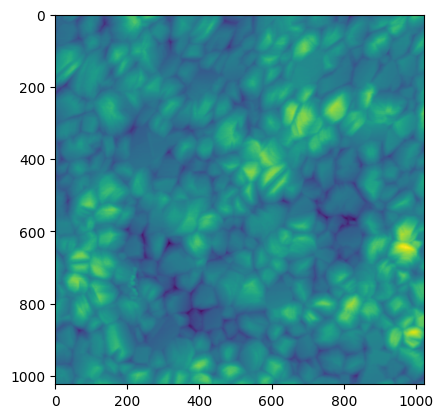

(1024, 1024)


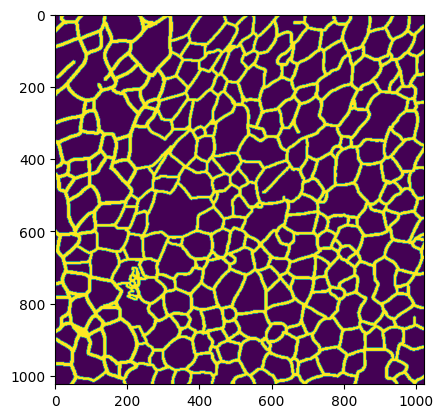

(1024, 1024)
[False  True]


In [335]:
index = np.random.randint(0, len(image_dataset)-1)
print(f'image dataset size: {len(image_dataset)}')
print(f'mask dataset size: {len(mask_dataset)}')

plt.imshow(image_dataset[index])
plt.show()
print(np.shape(image_dataset[index]))


plt.imshow(mask_dataset[index])
plt.show()
print(np.shape(mask_dataset[index]))
print(np.unique(mask_dataset[index]))

In [336]:
# Normalise the training images. The images are in 0-255 range with 3 channels
# 1600, 256, 256, 1
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1), 3)
# Do not normalize the masks, just rescale them to 0-1 range, because they do not have 3 colour channels.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)

print(image_dataset.shape)
print(mask_dataset.shape)
print(np.unique(image_dataset))
print(f'min, max image dataset: {np.min(image_dataset), np.max(image_dataset)}')
print(np.unique(mask_dataset))

(24, 1024, 1024, 1)
(24, 1024, 1024, 1)
[0.00717944 0.00719734 0.00741585 ... 0.05799835 0.05819304 0.05828127]
min, max image dataset: (0.007179436201422949, 0.058281269212890896)
[False  True]


In [337]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)

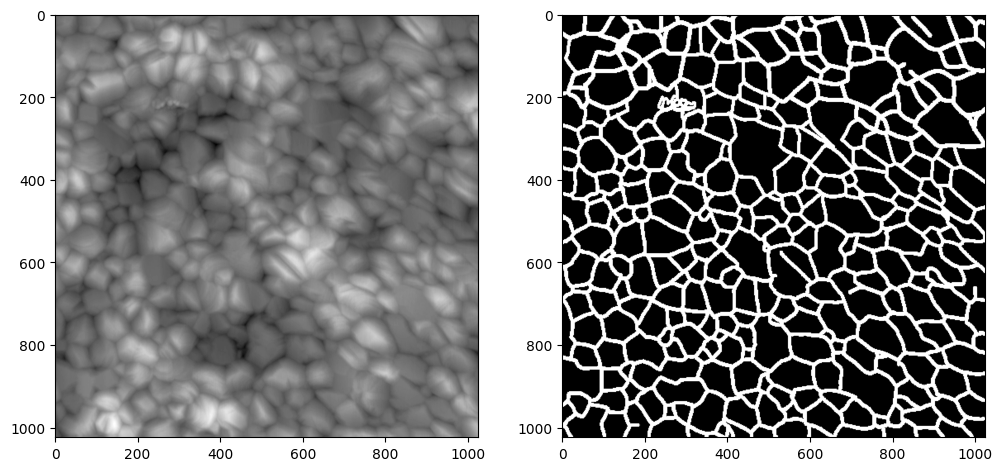

In [338]:
# Check things are working correctly
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.show()

In [339]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_228 (Conv2D)            (None, 1024, 1024,   160         ['input_13[0][0]']               
                                16)                                                               
                                                                                                  
 dropout_108 (Dropout)          (None, 1024, 1024,   0           ['conv2d_228[0][0]']             
                                16)                                                        

In [ ]:
# Can load the model:
# model.load_weights('mitochondria_test.hdf5')

In [340]:
history = model.fit(
    X_train,
    y_train,
    batch_size=1,
    verbose=1,
    epochs=50,
    validation_data=(X_test, y_test),
    shuffle=False
)

model.save('perovskite_test.hdf5')

Epoch 1/50


2023-04-04 22:41:41.137428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.7492

2023-04-04 22:41:53.887179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 14s 584ms/step - loss: 0.6445 - accuracy: 0.7492 - val_loss: 0.6155 - val_accuracy: 0.8026
Epoch 2/50
21/21 [==============================] - 11s 547ms/step - loss: 0.5506 - accuracy: 0.7716 - val_loss: 0.4993 - val_accuracy: 0.8026
Epoch 3/50
21/21 [==============================] - 12s 551ms/step - loss: 0.5382 - accuracy: 0.7717 - val_loss: 0.4842 - val_accuracy: 0.8026
Epoch 4/50
21/21 [==============================] - 11s 547ms/step - loss: 0.5394 - accuracy: 0.7717 - val_loss: 0.4769 - val_accuracy: 0.8026
Epoch 5/50
21/21 [==============================] - 12s 561ms/step - loss: 0.5273 - accuracy: 0.7717 - val_loss: 0.4740 - val_accuracy: 0.8026
Epoch 6/50
21/21 [==============================] - 12s 559ms/step - loss: 0.5248 - accuracy: 0.7717 - val_loss: 0.4680 - val_accuracy: 0.8026
Epoch 7/50
21/21 [==============================] - 12s 559ms/step - loss: 0.5229 - accuracy: 0.7717 - val_loss: 0.4632 - val_accuracy: 0.8026
Epoch 8/50

In [341]:
# Check model accuracy
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

2023-04-04 22:59:13.371141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 695ms/step - loss: 0.2199 - accuracy: 0.9060
Accuracy =  90.599125623703 %


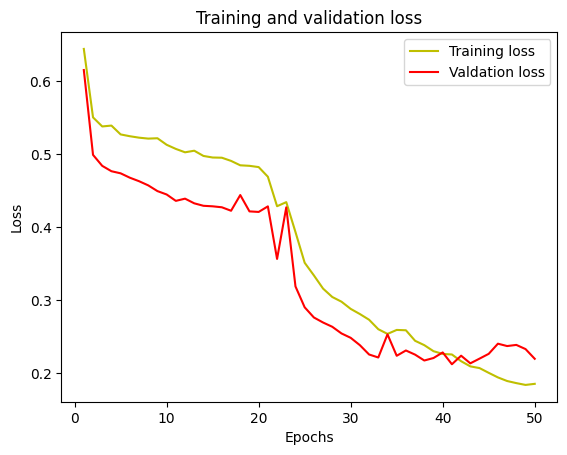

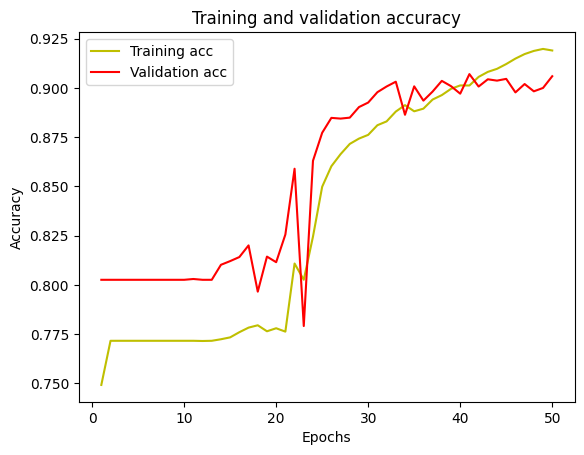

In [342]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Valdation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [343]:
# Note that for semantic segmentation, accuracy is not the correct metric.

# Calculate IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5 # this value is a probability cutoff

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print(f"IoU score: {iou_score}")

2023-04-04 22:59:19.860264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 298ms/step
IoU score: 0.6256163747102484


1/1 [==============================] - 0s 283ms/step


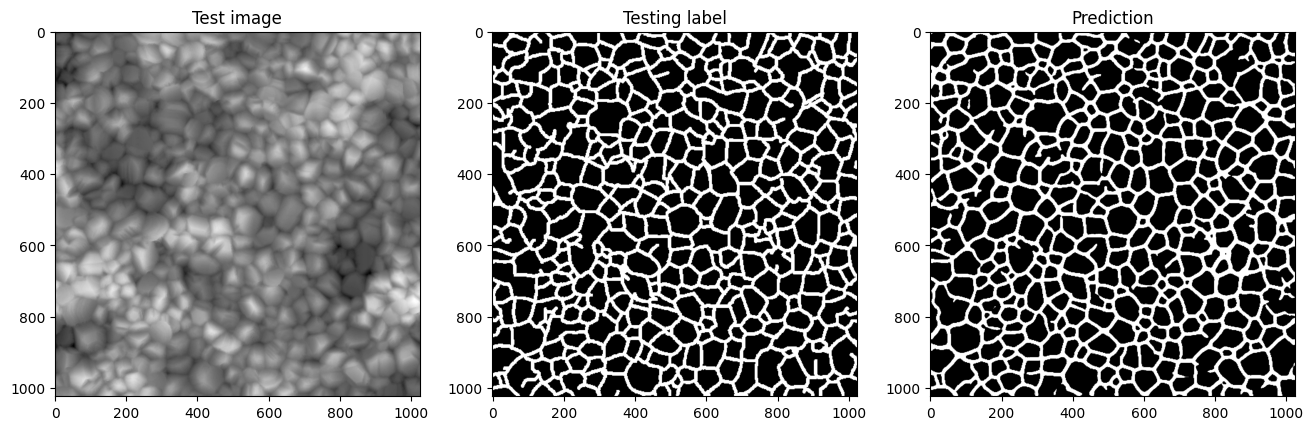

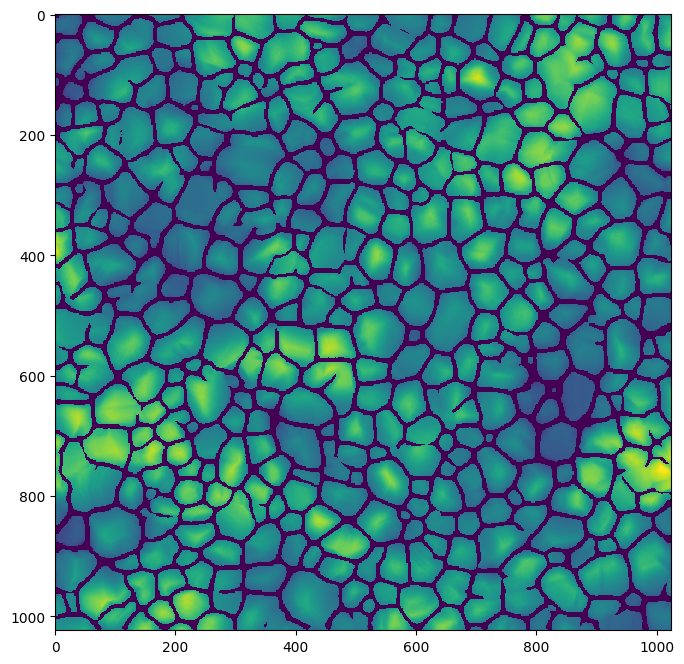

In [344]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Test image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.title('Testing label')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction')
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_img)
ax.imshow(np.ma.masked_where(prediction == 0, prediction))

original shape: 512.0
(256, 256)
min, max values: (38, 215)
(1024, 1024)
to predict shape: (1, 1024, 1024)
to predict shape: (1, 1024, 1024, 1)
(1, 1024, 1024, 1)
1/1 [==============================] - 0s 16ms/step


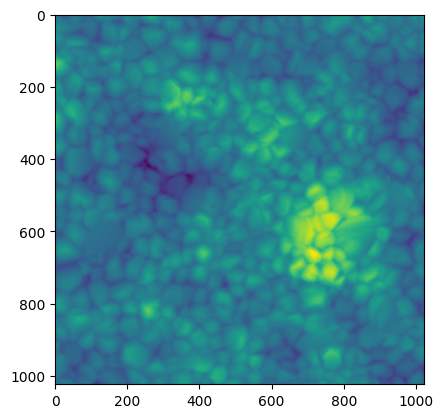

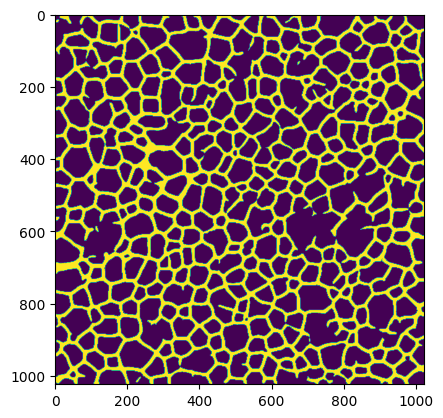

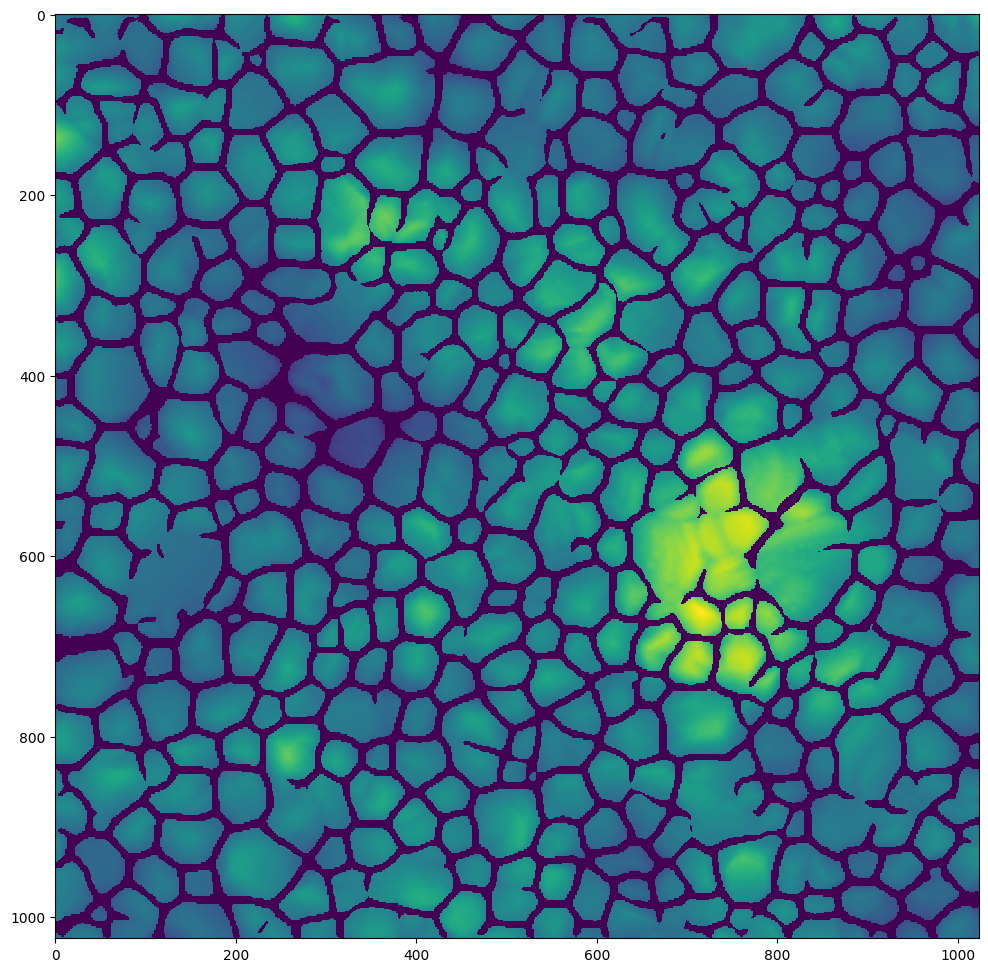

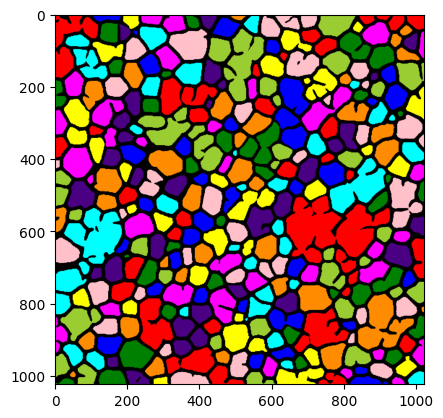

In [348]:
# Try another image
image = cv2.imread('./dl_data/to_be_labelled/20230207_MeO_perov_10um.0_00001.png', 0)
print(f'original shape: {np.sqrt(image.size)}')
image = image[100:356, 100:356]
print(image.shape)
print(f'min, max values: {np.min(image), np.max(image)}')
image=  Image.fromarray(image)
image = image.resize((SIZE, SIZE))
image= np.array(image)
print(image.shape)

# test_img = X_test[test_img_number]
# test_img = image
# test_img_norm=test_img[:, :, 0][:, :, None]
# test_img_input = np.expand_dims(test_img_norm, 0)

to_predict = []
to_predict.append(image)

to_predict = np.array(to_predict)
print(f'to predict shape: {to_predict.shape}')
to_predict = np.expand_dims(normalize(to_predict), 3)
print(f'to predict shape: {to_predict.shape}')

test_img = to_predict[0]
test_img = test_img[:, :, 0][:, :, None]
test_img = np.expand_dims(test_img, 0)
print(test_img.shape)

prediction = (model.predict(test_img)[0, :, :, 0] > 0.5).astype(np.uint8)
plt.imshow(image)
plt.show()
plt.imshow(prediction)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image)
ax.imshow(np.ma.masked_where(prediction == 0, prediction))
plt.show()

from skimage.morphology import label
from skimage.color import label2rgb
labelled = label(prediction == 0)
coloured = label2rgb(labelled)
plt.imshow(coloured)